<a href="https://colab.research.google.com/github/samirapakravan/ComputerVision/blob/main/LENET_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LENET on Fashion MNIST with batch normalization

https://www.youtube.com/watch?v=mhEN2rRV3W8

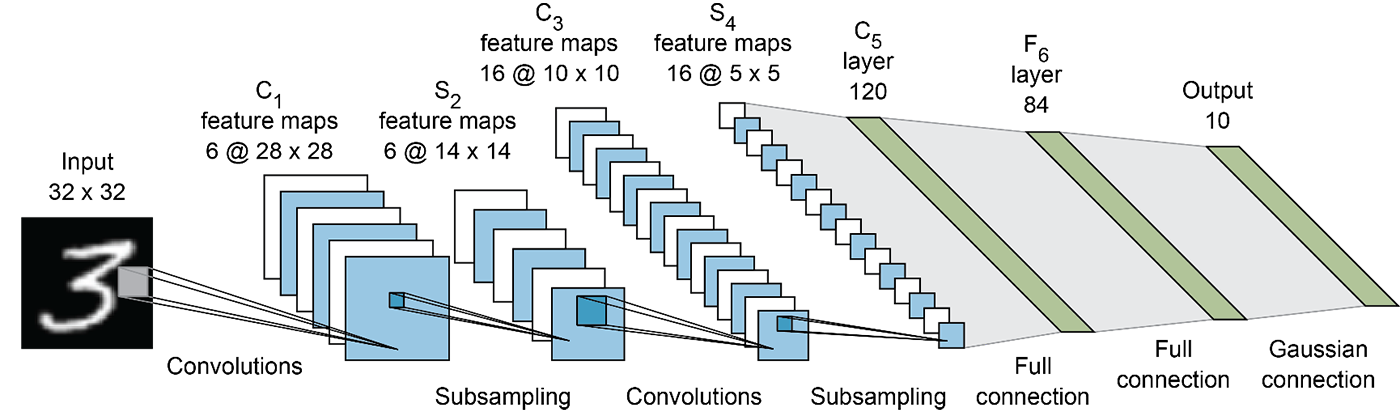

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
            transforms.Resize((32,32)),  # if work with fashionMNIST it is 28x28 but LENET input must be 32x32
            transforms.ToTensor(),              # make data in input form
            transforms.Normalize((0.5),(0.5))]) # normalize data, it is not batch norm

train_data = datasets.FashionMNIST(root='../content', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST(root='../content', download=True, train=False, transform=transform)

In [ ]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../content
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
train_data[0][0].shape

torch.Size([1, 32, 32])

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64 , shuffle=False)

In [ ]:
t = enumerate(train_loader)
b, (img, label) = next(t)
print(f'batch:{b}  image:{img.shape}  label:{label.shape}')

batch:0  image:torch.Size([64, 1, 32, 32])  label:torch.Size([64])


In [ ]:
class LENET(nn.Module):
  def __init__(self):
    super().__init__()


    self.convolutional_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # (batch, 1, 28,28)
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2),                               # (b, 1, 14, 14)
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), # (b, 1, 10, 10)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),                               # (b, 1, 5, 5)
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.ReLU()
    )

    self.linear_layer = nn.Sequential(
        nn.Linear(in_features = 120, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self, X):
    X = self.convolutional_layer(X)
    X = torch.flatten(X,1)
    X = self.linear_layer(X)
    X = F.softmax(X, dim=1)
    return X

In [ ]:
model = LENET()
model

LENET(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs=10
train_losses = []
test_losses = []

for i in range(epochs):
  for b, (X_train, y_train) in enumerate(train_loader):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{i}   Loss:{loss}')
  train_losses.append(loss)


  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_eval = model(X_test)
      loss = loss_fn(y_eval, y_test)

    test_losses.append(loss)


Epoch:0   Loss:1.5963332653045654
Epoch:1   Loss:1.5252045392990112
Epoch:2   Loss:1.510896921157837
Epoch:3   Loss:1.6548577547073364
Epoch:4   Loss:1.59949791431427
Epoch:5   Loss:1.6165556907653809
Epoch:6   Loss:1.4925190210342407
Epoch:7   Loss:1.566572666168213
Epoch:8   Loss:1.5231995582580566
Epoch:9   Loss:1.5135877132415771


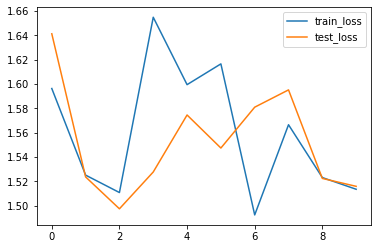

In [ ]:
plt.plot([l.item() for l in train_losses], label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()

# With batch norm

In [ ]:
class LENET_wBN(nn.Module):
  def __init__(self):
    super().__init__()


    self.convolutional_layer = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # (batch, 1, 28,28)
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2),                               # (b, 1, 14, 14)

        nn.BatchNorm2d(6),

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), # (b, 1, 10, 10)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),                               # (b, 1, 5, 5)

        nn.BatchNorm2d(16),

        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.ReLU()
    )

    self.linear_layer = nn.Sequential(
        nn.Linear(in_features = 120, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self, X):
    X = self.convolutional_layer(X)
    X = torch.flatten(X,1)
    X = self.linear_layer(X)
    X = F.softmax(X, dim=1)
    return X

In [ ]:
model_wBN = LENET_wBN()
model_wBN

LENET_wBN(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (9): ReLU()
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_wBN.parameters(), lr=0.001)

In [ ]:
epochs=10
train_losses = []
test_losses = []

for i in range(epochs):
  for b, (X_train, y_train) in enumerate(train_loader):
    y_pred = model_wBN(X_train)
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{i}   Loss:{loss}')
  train_losses.append(loss)


  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_eval = model_wBN(X_test)
      loss = loss_fn(y_eval, y_test)

    test_losses.append(loss)

Epoch:0   Loss:1.7514994144439697
Epoch:1   Loss:1.6486002206802368
Epoch:2   Loss:1.6255971193313599
Epoch:3   Loss:1.5582109689712524
Epoch:4   Loss:1.6836605072021484
Epoch:5   Loss:1.5845909118652344
Epoch:6   Loss:1.5235852003097534
Epoch:7   Loss:1.558035969734192
Epoch:8   Loss:1.4612433910369873
Epoch:9   Loss:1.4645085334777832


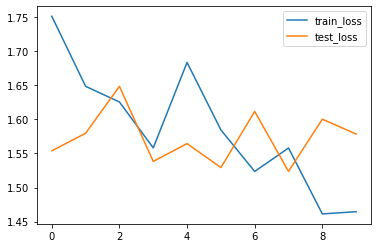

In [ ]:
plt.plot([l.item() for l in train_losses], label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()